#### includes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import mlflow
import pytorch_lightning as pl
from pytorch_lightning.utilities.cloud_io import load as pl_load
import torch
import sys

plt.rcParams["figure.figsize"] = (18, 5)

In [3]:
import sources
from steered_cnn.utils.rotequivariance_toolbox import *
from steered_cnn.steered_conv.steerable_filters import radial_steerable_filter, plot_filter
from steered_cnn.utils.clip_pad import clip_pad_center
from steered_cnn.steered_conv import SteerableKernelBase
from src.trainer import BinaryClassifierNet
from sources import load_dataset, parse_config, setup_model

### Cos Sin Combination Test

In [24]:
alpha = torch.linspace(0, 2*np.pi, 4)
k_max = 5
kalpha = torch.stack([k*alpha for k in range(1,k_max+1)])
true_cos_sin_kalpha = torch.stack([torch.cos(kalpha), torch.sin(kalpha)])

In [25]:
from steered_cnn.steered_conv.steerable_filters import cos_sin_ka, cos_sin_ka_stack
fast_cos_sin_kalpha = cos_sin_ka_stack(torch.cos(alpha), torch.sin(alpha), k_max)
diff = true_cos_sin_kalpha-fast_cos_sin_kalpha
print('Average Diff:')
pd.DataFrame({'diff cos':diff[0].mean(-1), 'diff sin': diff[0].mean(-1), 'cos':fast_cos_sin_kalpha[0,:,1], 'sin': fast_cos_sin_kalpha[1,:,1]}, index=list(range(1,k_max+1)))

Average Diff:


,diff cos,diff sin,cos,sin
1,0.000000e+00,0.000000e+00,-0.5,8.660254e-01
2,-7.450581e-09,-7.450581e-09,-0.5,-8.660255e-01
3,1.490116e-08,1.490116e-08,1.0,1.788139e-07
4,2.235174e-08,2.235174e-08,-0.5,8.660253e-01
5,5.960464e-08,5.960464e-08,-0.5,-8.660256e-01


**Not Unary cos sin**

In [30]:
a = 3

fast_cos_sin_kalpha = cos_sin_ka_stack(torch.cos(alpha)*a, torch.sin(alpha)*a, k_max)
diff = true_cos_sin_kalpha*a-fast_cos_sin_kalpha
print('Average Diff:')
pd.DataFrame({'cos fast':fast_cos_sin_kalpha[0,:,1], 'cos diff':abs(diff[0]).mean(-1), 'cos true':true_cos_sin_kalpha[0,:,1]*a,
              'sin fast': fast_cos_sin_kalpha[1,:,1], 'sin diff': abs(diff[1]).mean(-1), 'sin true':true_cos_sin_kalpha[1,:,1]*a},
             index=list(range(1,k_max+1)))

Average Diff:


,cos fast,cos diff,cos true,sin fast,sin diff,sin true
1,-1.500000,0.000000e+00,-1.5,2.598076e+00,0.000000e+00,2.598076e+00
2,-1.500000,5.960464e-08,-1.5,-2.598077e+00,5.960464e-08,-2.598076e+00
3,3.000000,0.000000e+00,3.0,7.152557e-07,4.688938e-07,5.245366e-07
4,-1.500001,1.788139e-07,-1.5,2.598076e+00,5.960464e-08,2.598076e+00
5,-1.499999,8.344650e-07,-1.5,-2.598077e+00,9.536743e-07,-2.598076e+00


### Steerable Test

In [14]:
base = SteerableKernelBase.from_steerable(4)
x = torch.linspace(-2,2,5)
x,y = torch.meshgrid(x,x)
K = (x+y)/4
K = K.reshape(1,1,5,5)
K = clip_pad_center(K, base.base.shape)

info = {}

W = base.approximate_weights(K, info)
print(f'mse:{info["mse"]:.3f}, r2:{info["r2"]:.3f}')

torch.set_printoptions(precision=3, sci_mode=False)
print(W)


mse:0.002, r2:0.987
tensor([[[    -0.000,      0.000,     -0.000,     -0.000,      0.145,
               0.906,      0.740,      0.000,     -0.000,      0.000,
               0.149,     -0.467,     -0.000,     -0.000,      0.061,
              -0.455,     -0.000,      0.129,     -0.000,      0.145,
               0.906,      0.740,     -0.000,      0.000,     -0.000,
              -0.149,      0.467,     -0.000,      0.000,      0.061,
              -0.455,     -0.000,     -0.129,     -0.000]]])


**Checking weight approximation**

mse:0.002, r2:0.987


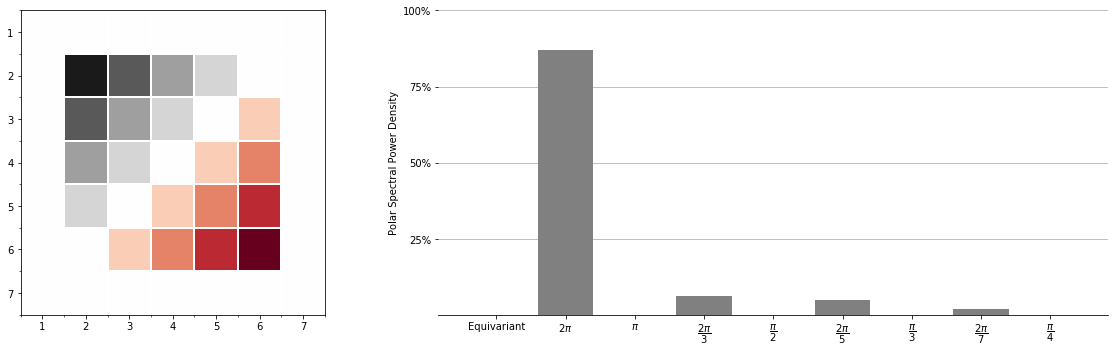

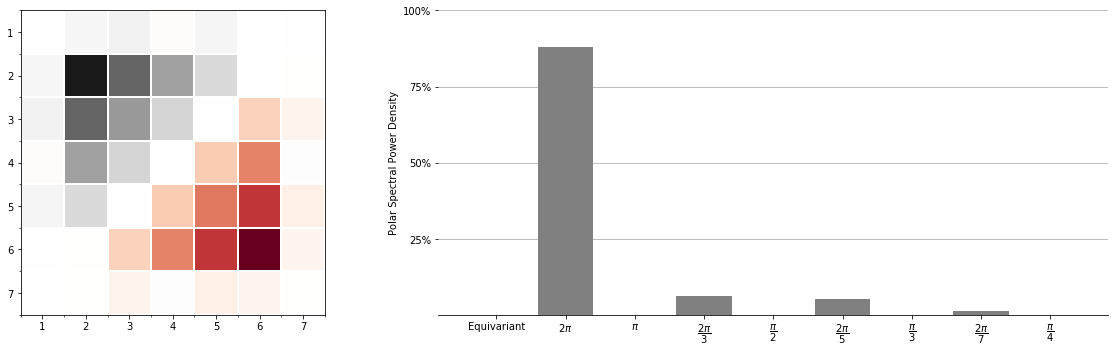

In [15]:
plot_filter(K[0,0], spd=True)
plot_filter(info['y_approx'][0,0], spd=True)
print(f'mse:{info["mse"]:.3f}, r2:{info["r2"]:.3f}')


**Checking filter rotation for different steer angle $\alpha$**

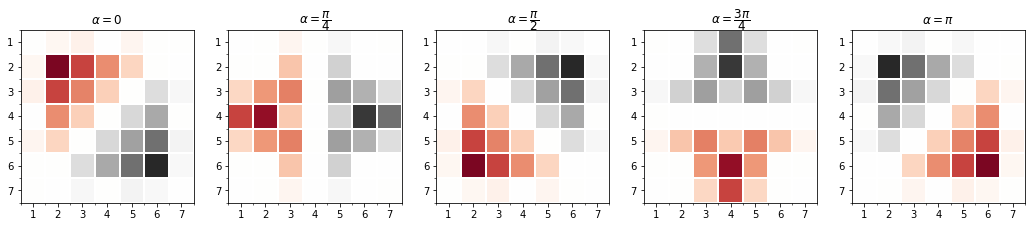

In [18]:
N = 4

I = torch.zeros((1,1,7,7))
I[:,:,3,3] = 1
fig, axs = plt.subplots(1,N+1)

alphas = np.linspace(0, np.pi, N+1, endpoint=True)
for i in range(N+1):
    plot_filter(base.conv2d(I,W, alpha=alphas[i])[0,0], plot=axs[i], vmax=1)
    axs[i].set_title(f'$\\alpha = {repr_pi_fraction(i,N)}$')

**Checking filter rotation for not unitary attention vector $\alpha$**

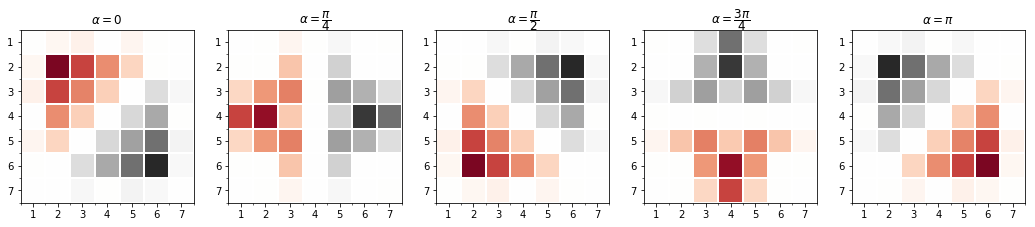

In [31]:
N = 4; a=3

I = torch.zeros((1,1,7,7))
I[:,:,3,3] = 1
fig, axs = plt.subplots(1,N+1)
alphas = np.linspace(0, np.pi, N+1, endpoint=True)[:, None, None, None, None]
alphas = a*torch.from_numpy(np.stack([np.cos(alphas), np.sin(alphas)], axis=1)).float()
for i in range(N+1):
    plot_filter(base.conv2d(I,W, alpha=alphas[i])[0,0], plot=axs[i], vmax=a)
    axs[i].set_title(f'$\\alpha = {repr_pi_fraction(i,N)}$')

**Checking filter rotation for image orienation**

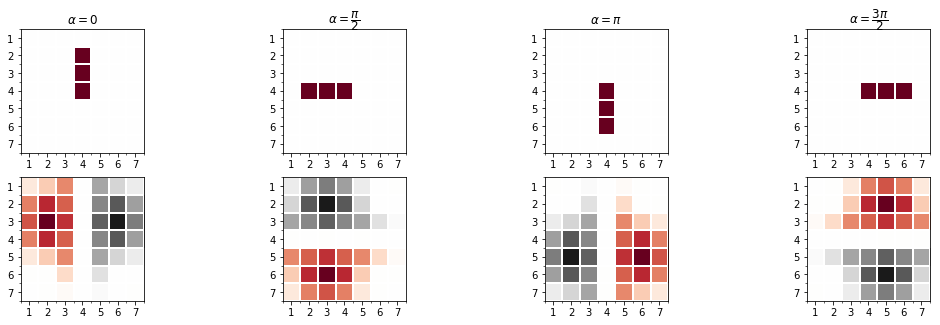

In [41]:
I0 = torch.zeros((1,1,7,7)); I0[:,:,1:4,3] = 1
I1 = torch.zeros((1,1,7,7));I1[:,:,3,1:4] = 1
I2 = torch.zeros((1,1,7,7));I2[:,:,3:6,3] = 1
I3 = torch.zeros((1,1,7,7));I3[:,:,3,3:6] = 1
I = [I0, I1, I2, I3]

fig, axs = plt.subplots(2,4)
alphas = np.linspace(0, 2*np.pi, 5, endpoint=True)[1:]
for i in range(4):
    plot_filter(I[i][0,0], plot=axs[0][i])
    plot_filter(base.conv2d(I[i],W, alpha=alphas[i]-(np.pi/4))[0,0], plot=axs[1][i])
    axs[0][i].set_title(f'$\\alpha = {repr_pi_fraction(i,2)}$')

**Resampling Artefact on Diamond**

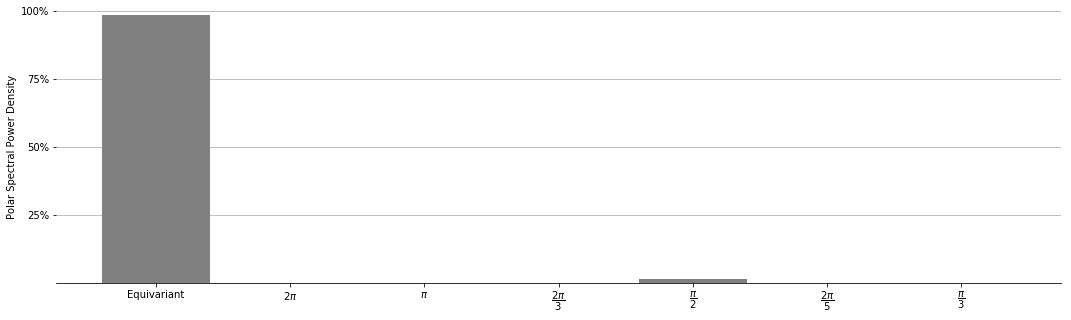

In [10]:
N = 12
alphas = -np.linspace(0, 2*np.pi, N, endpoint=False)
rotated_I = unrotate(torch.stack([base.conv2d(I,W, alpha=alphas[i])[0] for i in range(N)]).detach().numpy())
_ = spectral_power(rotated_I,plot=True)

**Resampling Artefact on Noise**

In [11]:
THETA = 12
thetas = np.linspace(0, 360, THETA, endpoint=False)
alphas = -torch.from_numpy(thetas)[:,None,None,None].float()*np.pi/180
cos_sin_alphas = torch.stack((torch.cos(alphas), torch.sin(alphas)))

I_n = clip_pad_center(torch.from_numpy(rotate(np.random.rand(3,120,120), thetas[1:])).float(), (256,256))

Spe0 min=0.6206958889961243, mean=0.8707698583602905, std=0.10544953495264053


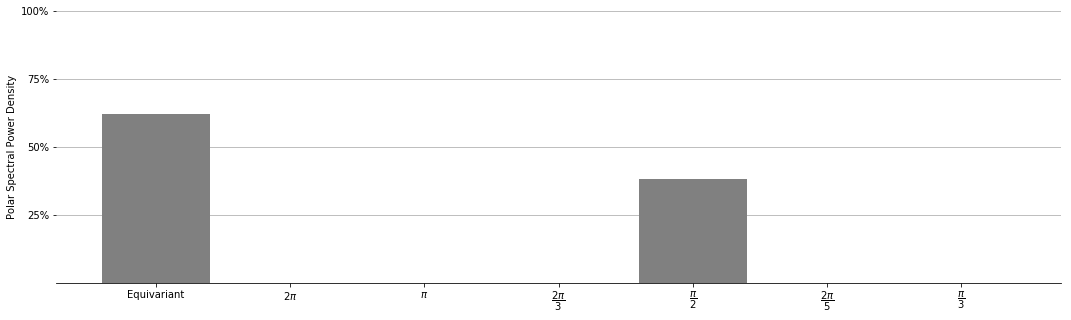

In [12]:
min_spe0 = 10
spe0 = []
for i in range(50):
    W_n = base.create_weights(3,1)
    y_n = torch.relu(base.conv2d(I_n,W_n, alpha=cos_sin_alphas, padding='true')).detach().numpy()
    rotated_I = unrotate(y_n, thetas[1:])
    spe = spectral_power(rotated_I)
    _spe0 = spe[0] / spe[:THETA//2].sum()
    spe0 += [_spe0]
    if min_spe0 > _spe0:
        min_spe0 = _spe0
        min_rotated_I = rotated_I
print(f'Spe0 min={min_spe0}, mean={np.mean(spe0)}, std={np.std(spe0)}')
_ = spectral_power(min_rotated_I, plot=True)

## Steerable Filters

/home/gaby/.conda/envs/nnet/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


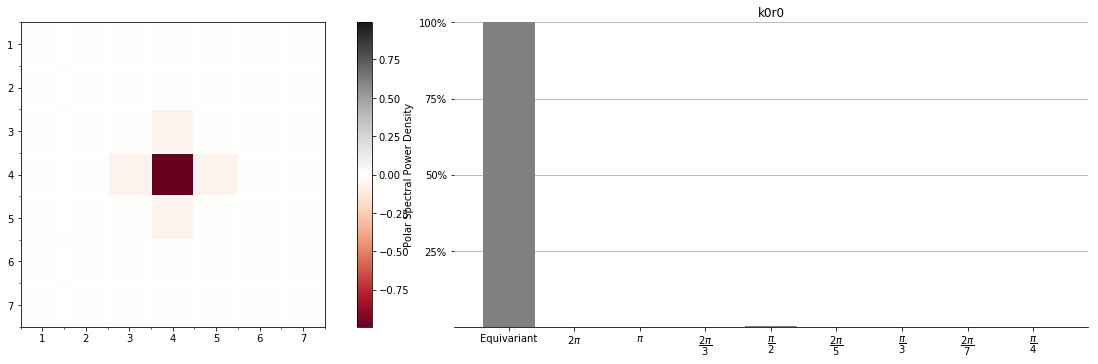

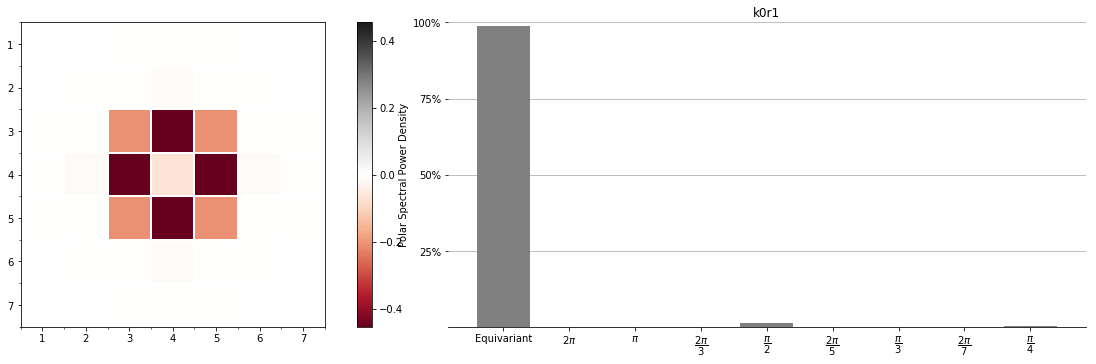

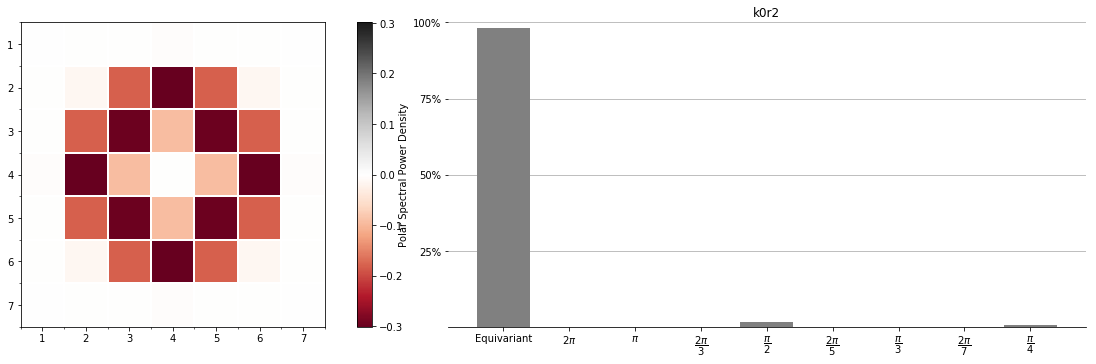

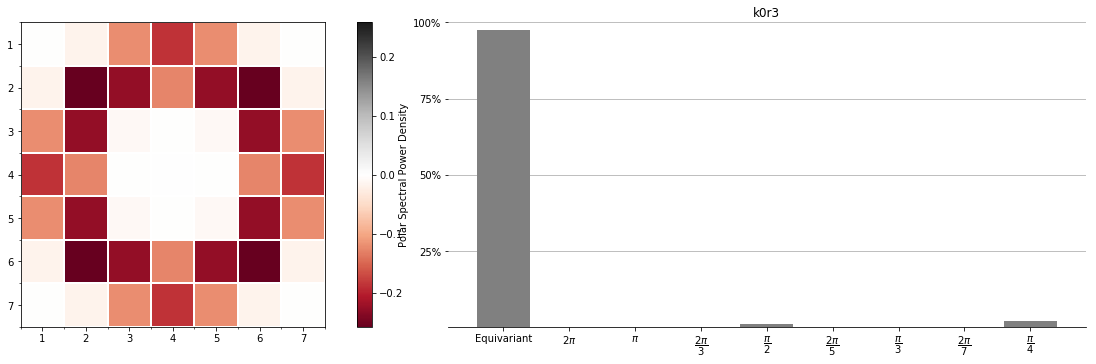

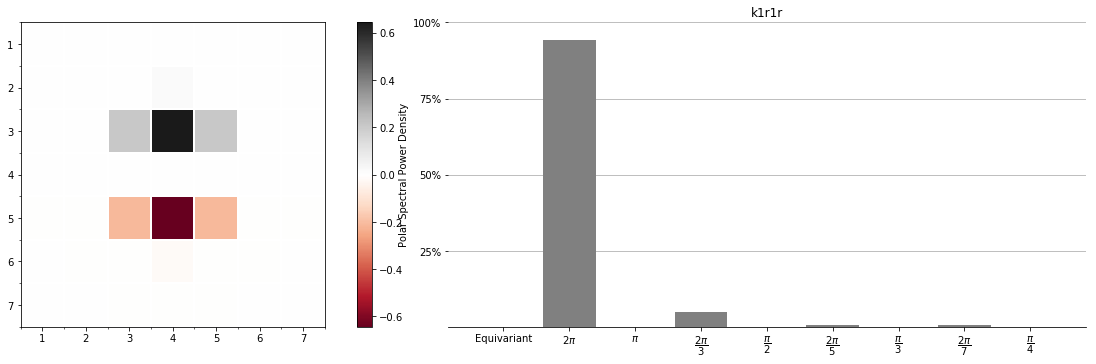

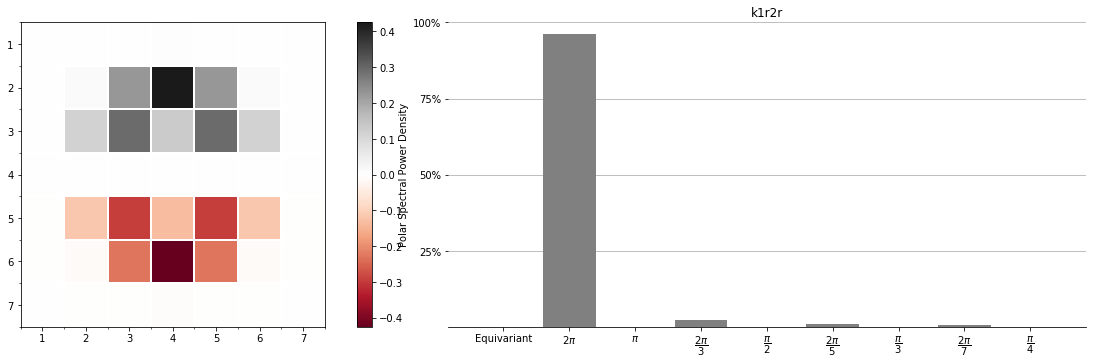

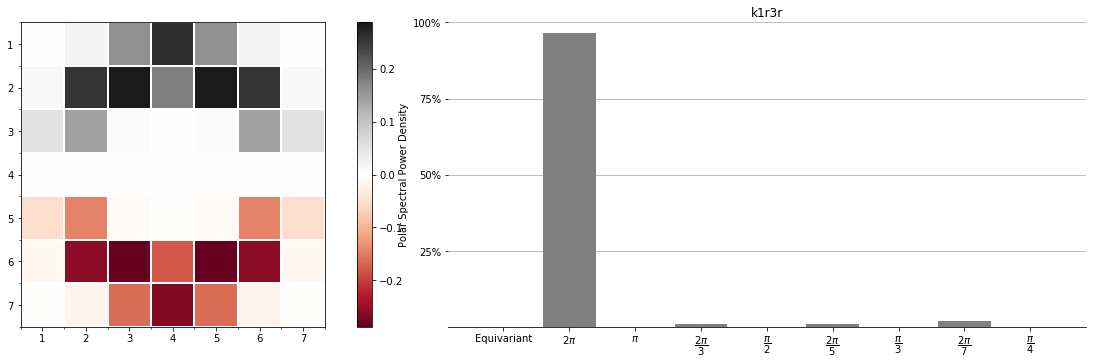

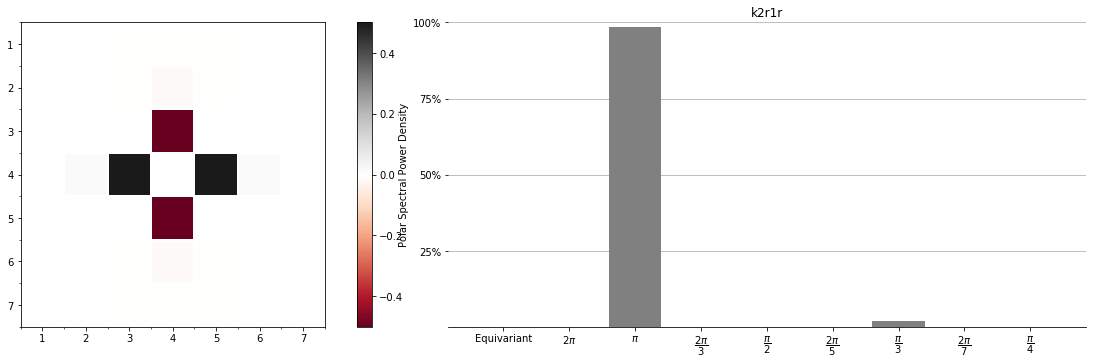

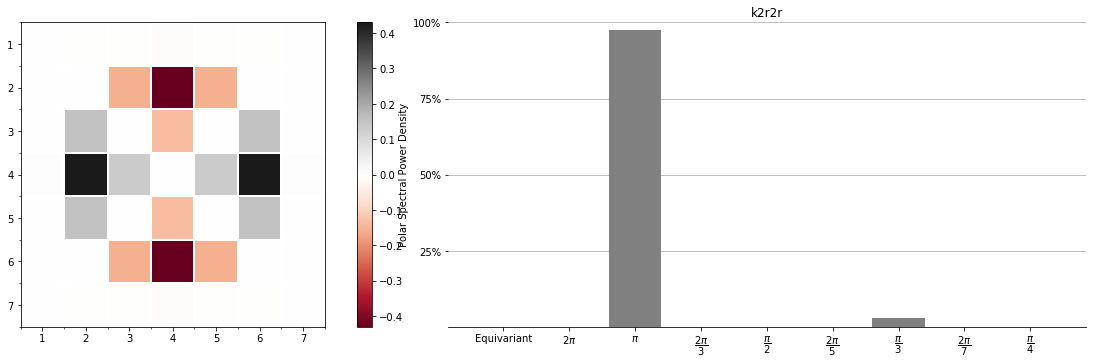

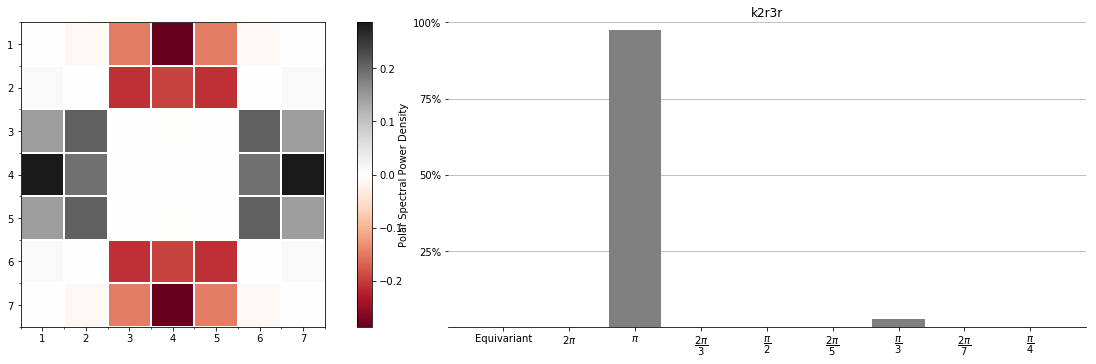

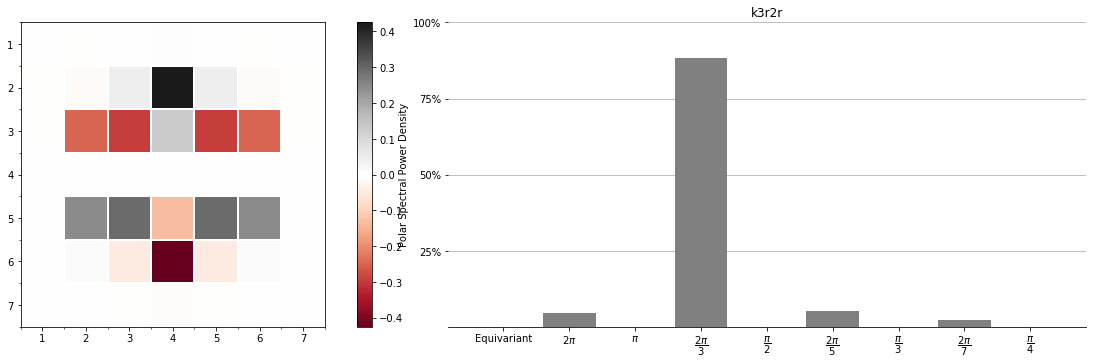

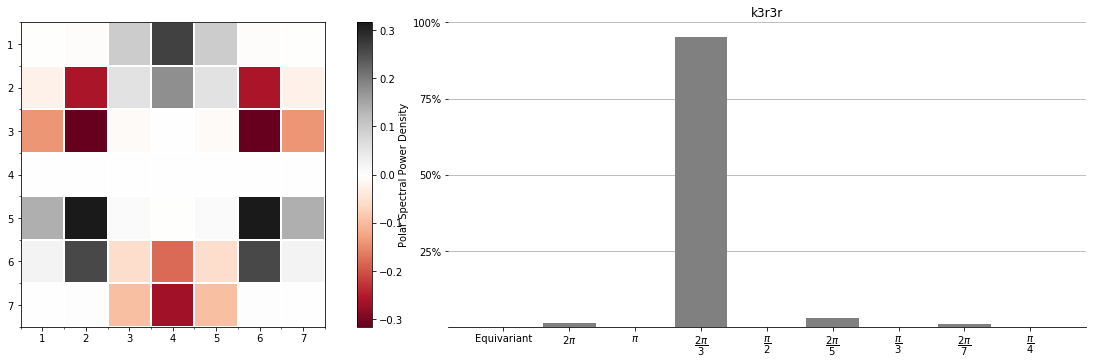

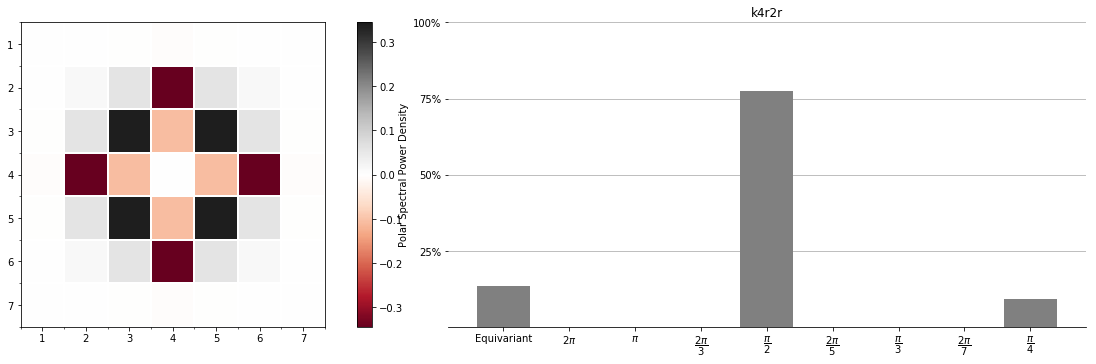

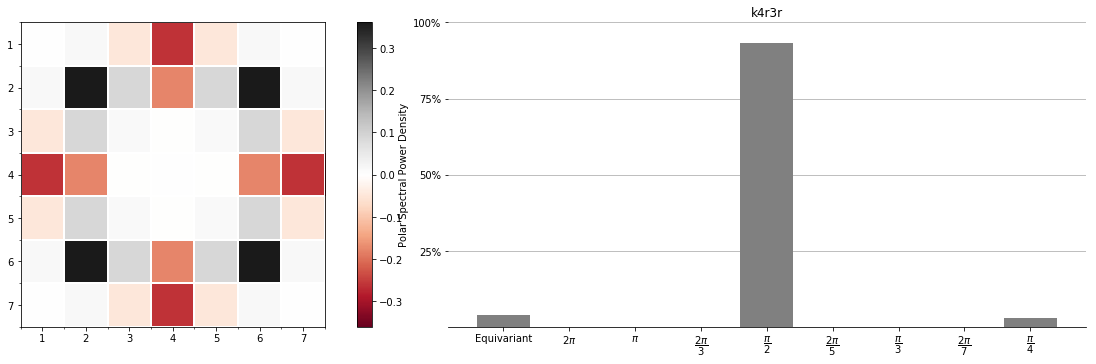

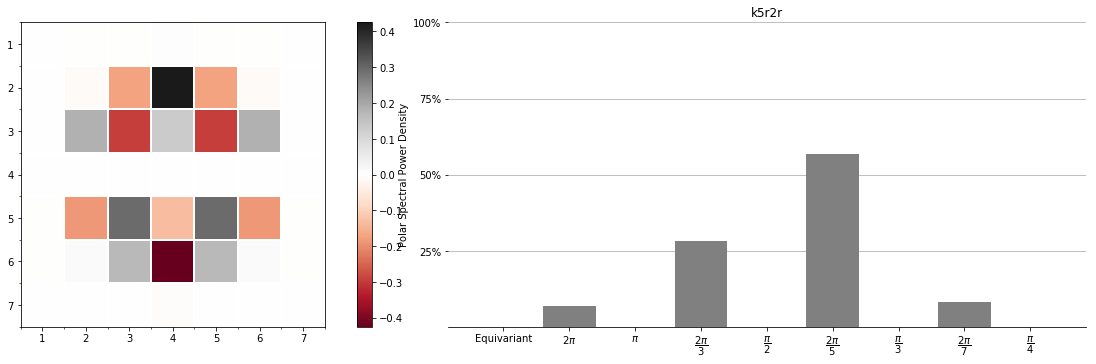

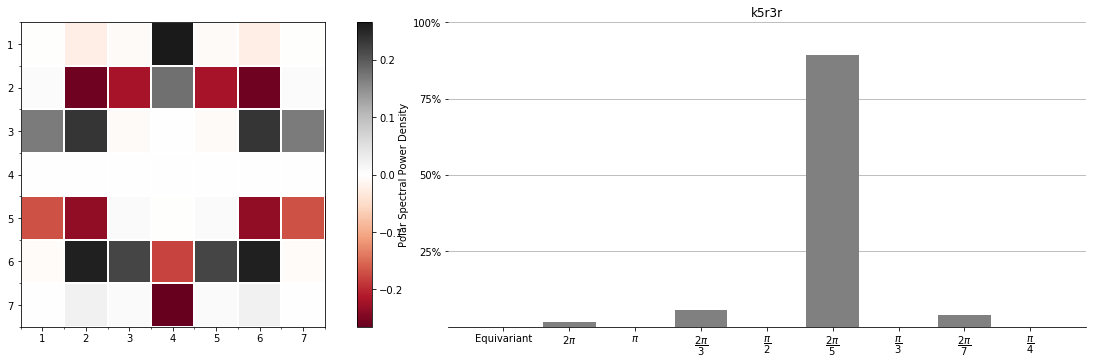

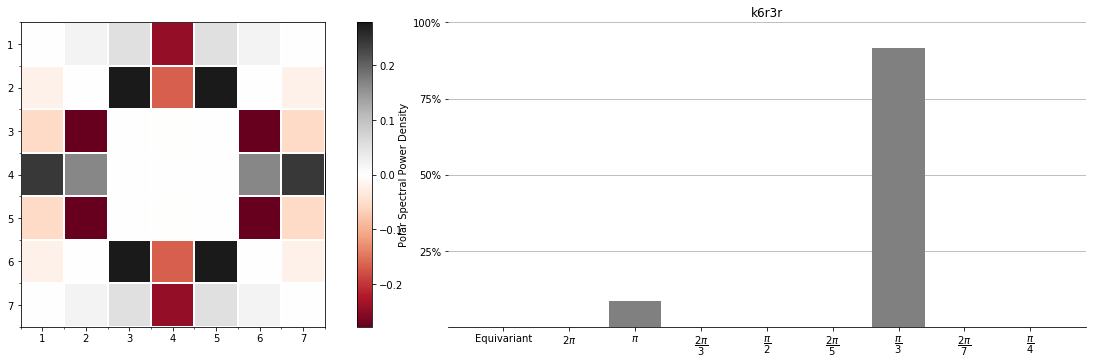

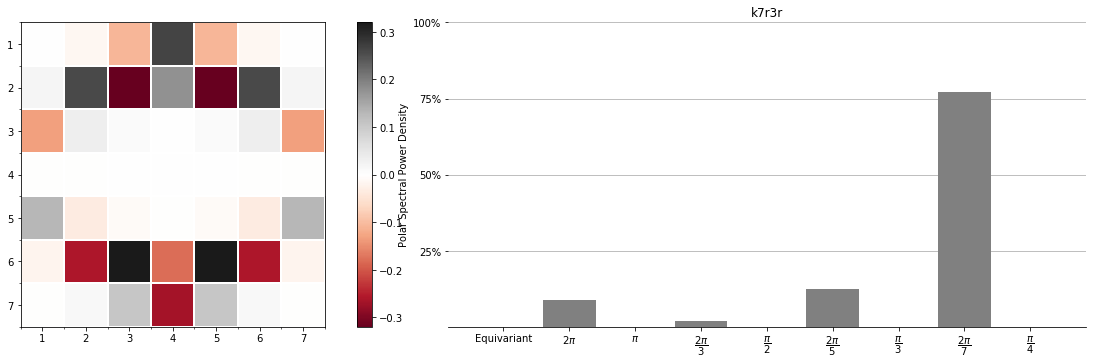

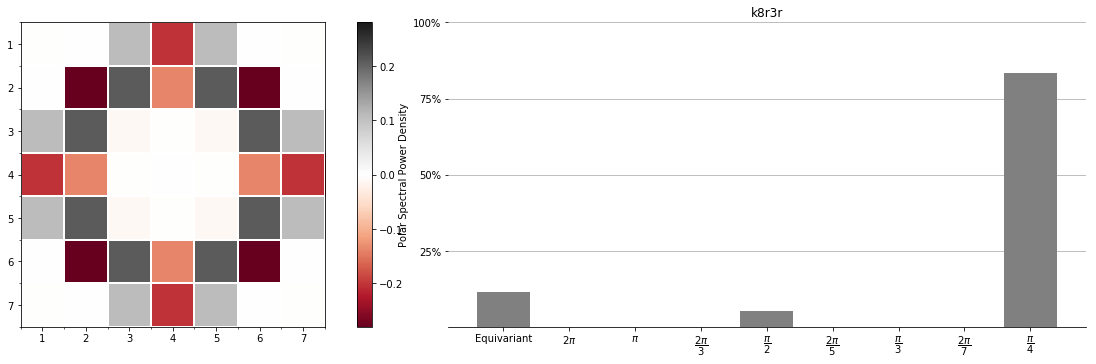

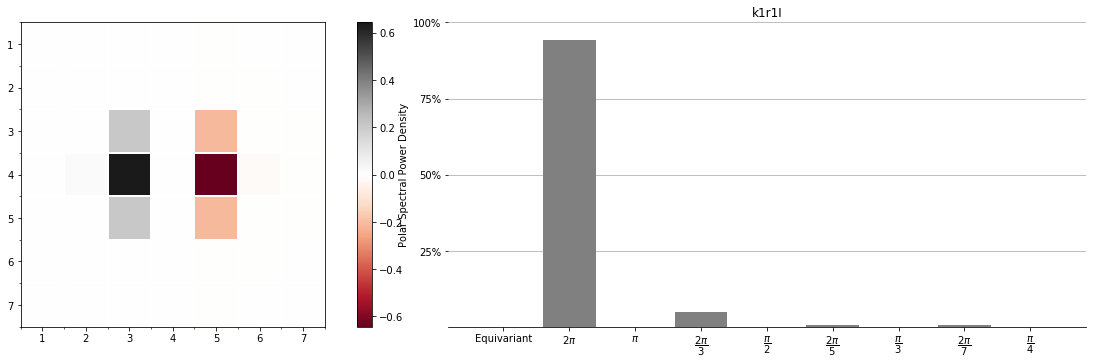

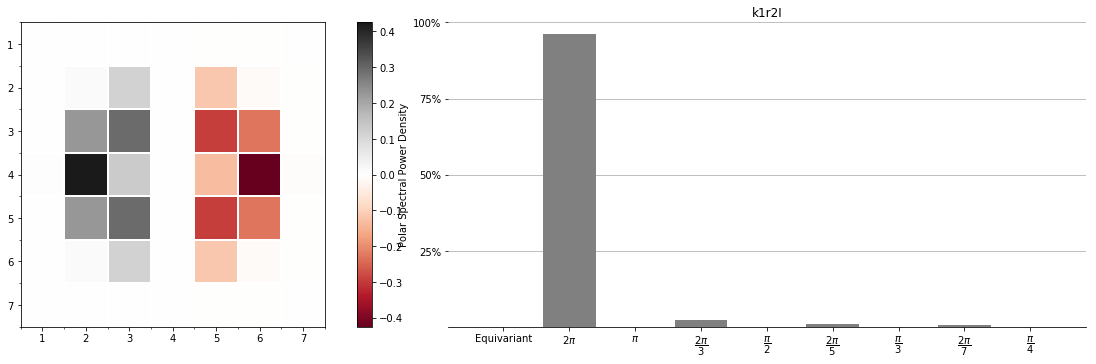

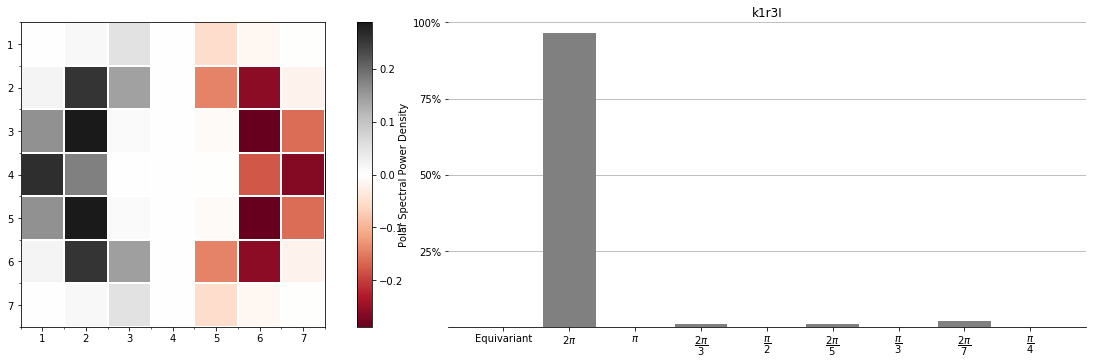

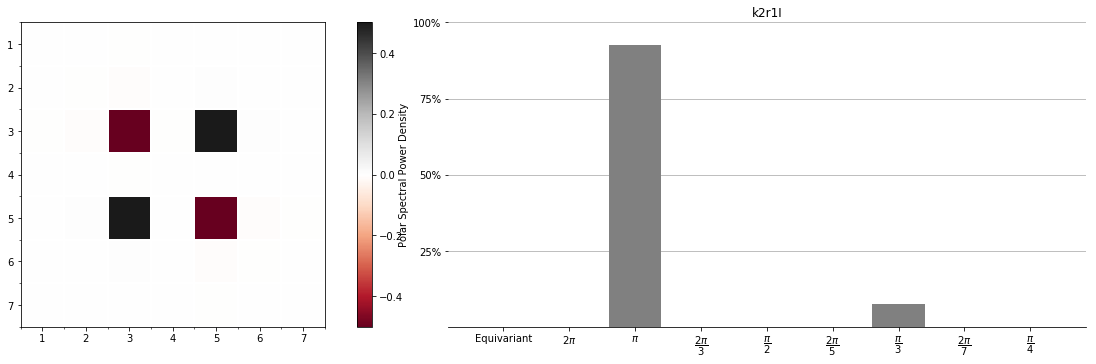

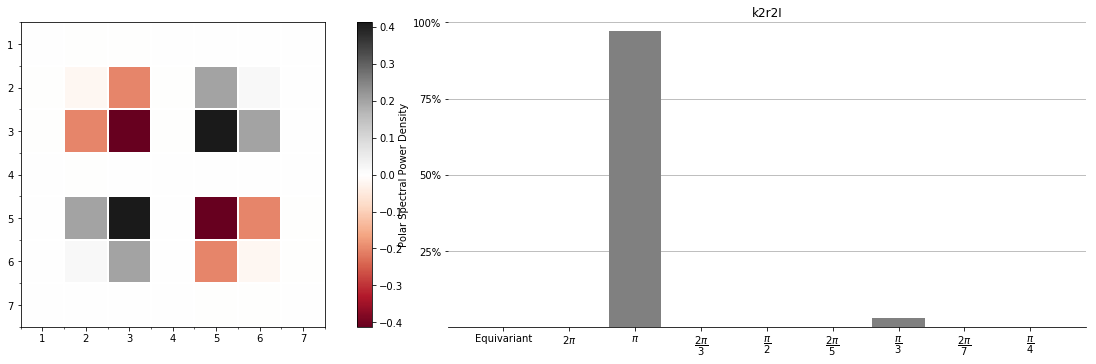

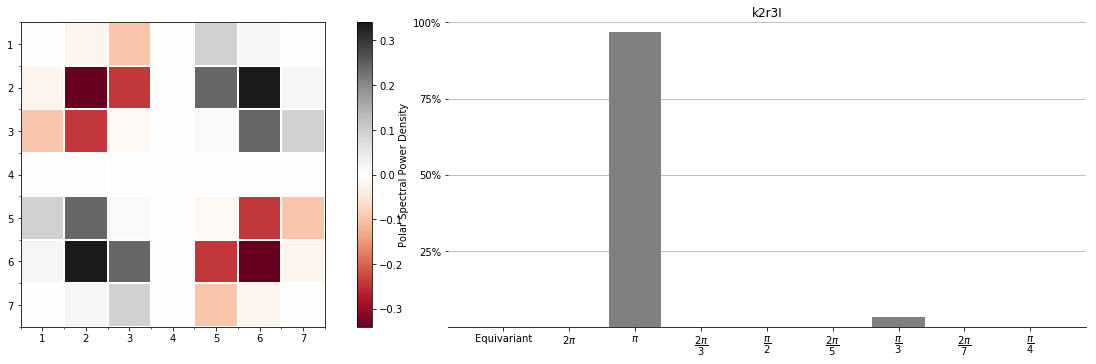

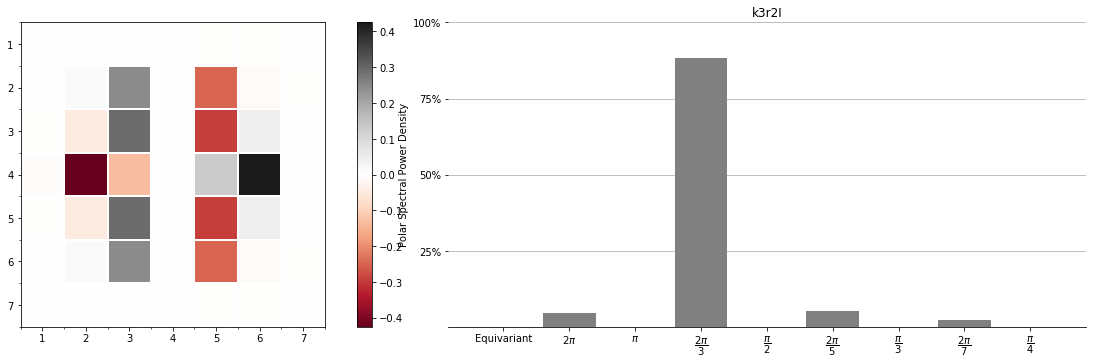

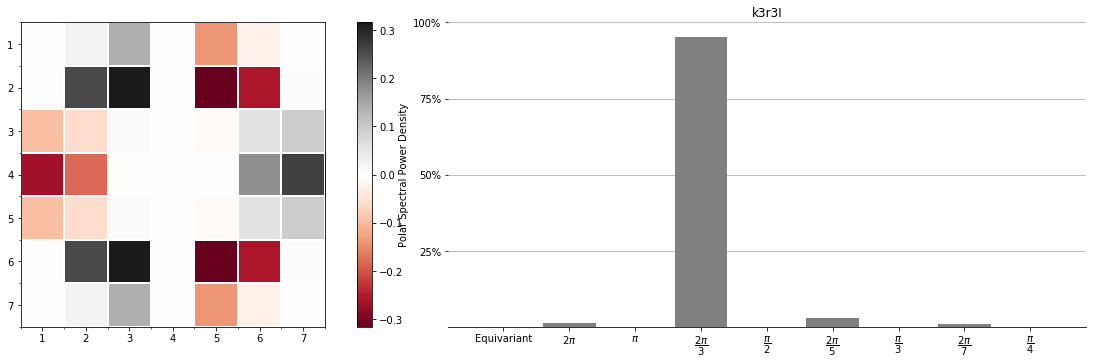

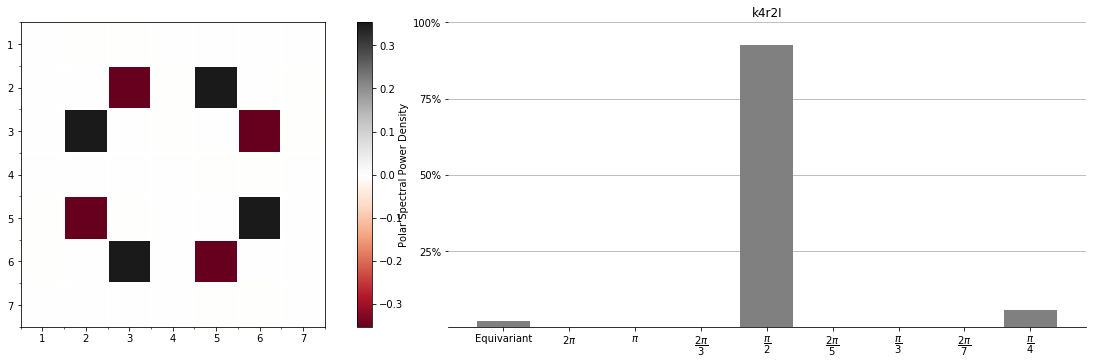

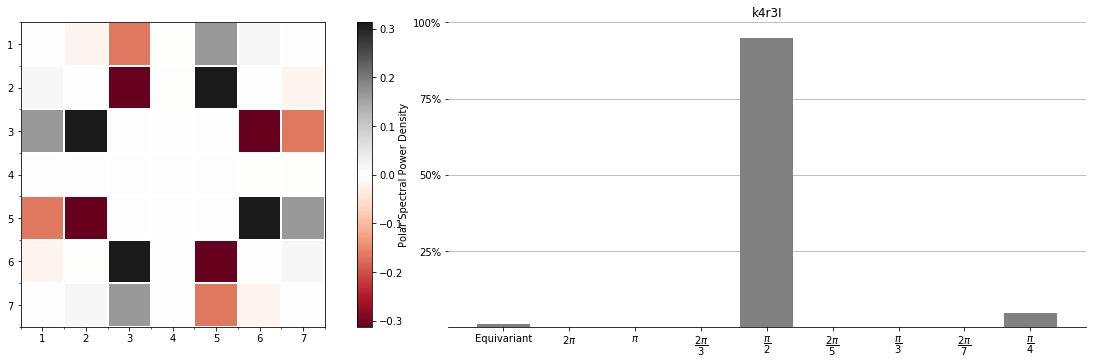

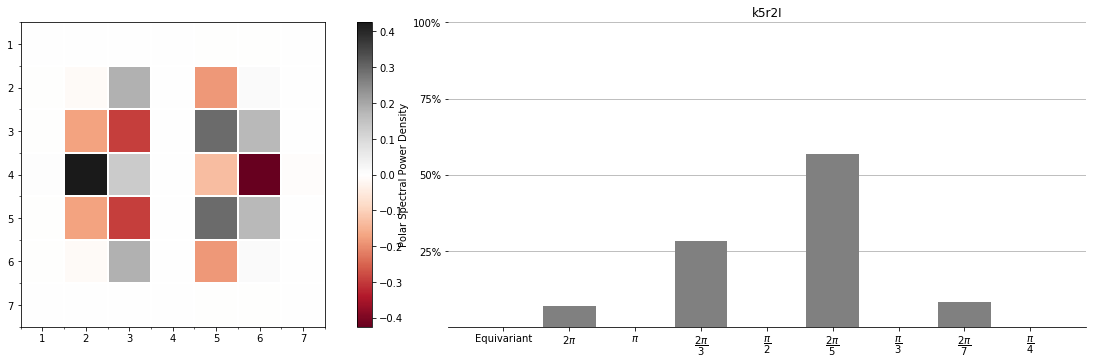

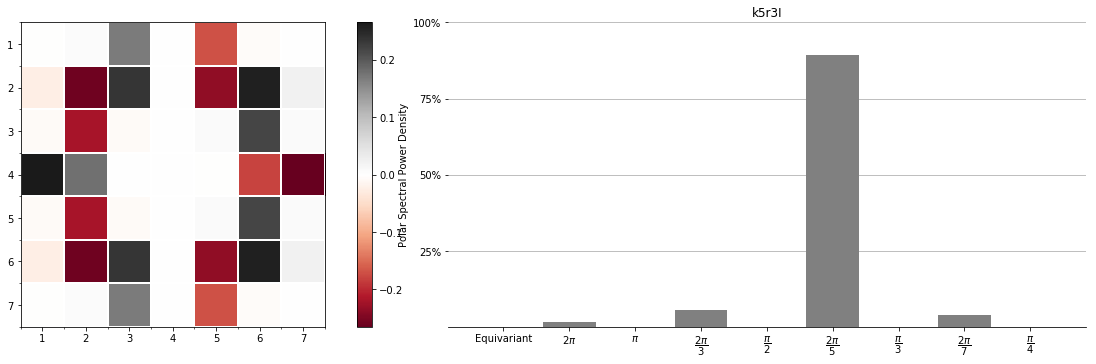

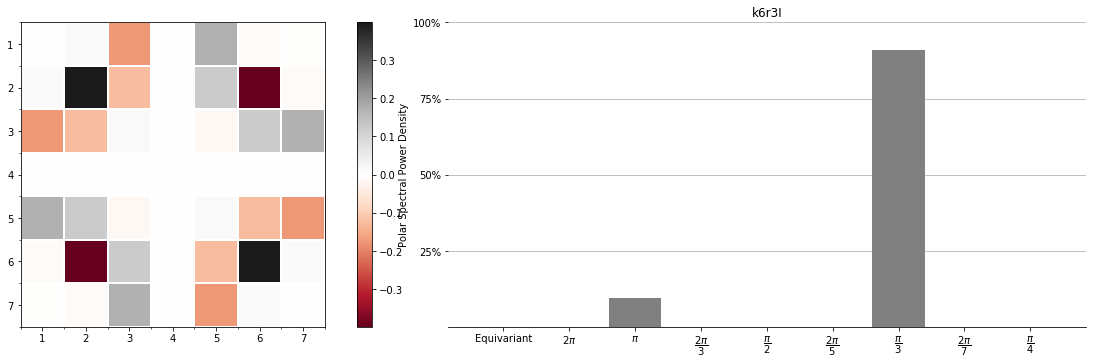

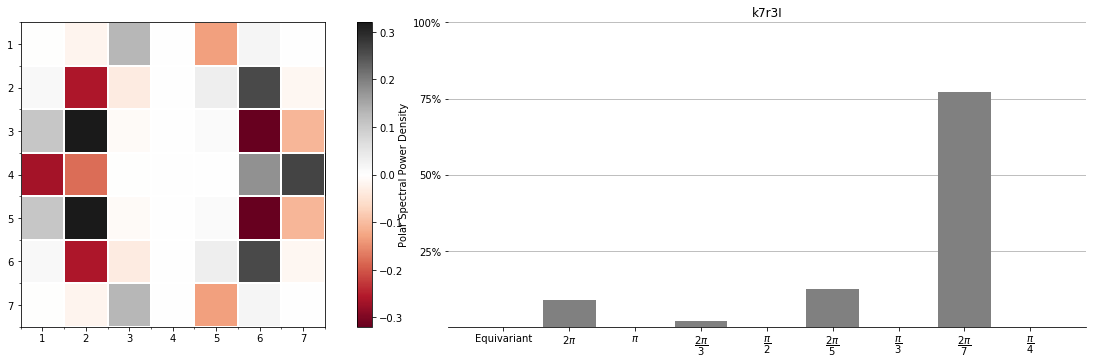

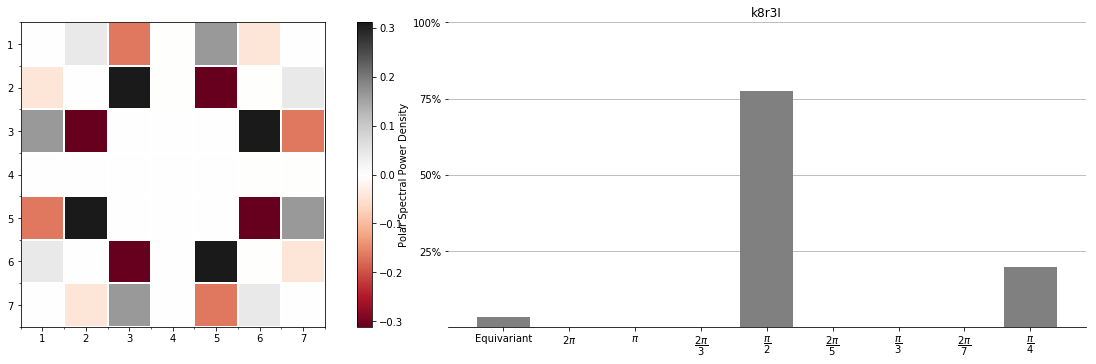

In [13]:
base = SteerableKernelBase.from_steerable(4)
for i, k_label in enumerate(base.kernels_label):
    plot_filter(base.base[i], spd=16, colorbar=True)
    plt.title(k_label)

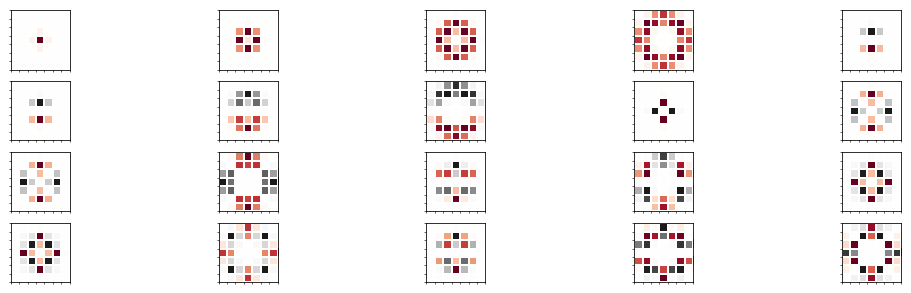

In [14]:
I = torch.zeros((1,1,7,7))
I[:,:,3,3] = 1
fig, axs = plt.subplots(4,5)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        plot_filter(base.base[i*4+j], plot=axs[i][j], axis=False)